In [33]:
import numpy as np
from sklearn.model_selection import train_test_split

import time
import os
import math
import argparse
from glob import glob
from collections import OrderedDict
import random
import warnings
from datetime import datetime
import joblib

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, LearningRateScheduler, TerminateOnNaN, LambdaCallback
from keras import Model, optimizers
from keras import regularizers

import archs
from metrics import *
from scheduler import *

from matplotlib import pyplot as plt

In [34]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()

# def load_data():
#     X = np.load('data/128x128x3_image.npy',allow_pickle=True)
#     y = np.load('data/label.npy',allow_pickle=True)
    
#     # le.fit(y)
#     # print(le.classes_)
#     # y = le.transform(y)
#     # print(X.shape, y.shape)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#     np.savez_compressed('data/celebrity-faces-dataset.npz', X_train, X_test, y_train, y_test)
    
# load_data()  

In [35]:
# load the face dataset
data = np.load('data/celebrity-faces-dataset.npz')
trainX, testX, trainy, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (718, 128, 128, 3) (718,) (180, 128, 128, 3) (180,)


In [36]:
print("Training Sample: ", trainX.shape, " || ", "Training Labels: ", trainy.shape)
print("Testing Sample: ", testX.shape, " || ", "Testing Labels: ", testy.shape)

# trainX = trainX[:, :, :, np.newaxis].astype('float32') / 255
# testX = testX[:, :, :, np.newaxis].astype('float32') / 255

#for RGB Image
trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255

# print("----------NORMALIZED & RESHAPED----------")
# print("Training Sample: ", trainX.shape, " || ", "Training Labels: ", trainy.shape)
# print("Testing Sample: ", testX.shape, " || ", "Testing Labels: ", testy.shape)

# trainy = keras.utils.to_categorical(trainy, 10)
# testy = keras.utils.to_categorical(testy, 10)

Training Sample:  (718, 128, 128, 3)  ||  Training Labels:  (718,)
Testing Sample:  (180, 128, 128, 3)  ||  Testing Labels:  (180,)


In [37]:
# reshaping the data
# trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],trainX.shape[2],1))
# testX = np.reshape(testX,(testX.shape[0],testX.shape[1],testX.shape[2],1))
# print(trainX.shape, testX.shape)

# Buidling Model

In [40]:
def build_model():
    
    BATCH_SIZE = 128
    EPOCHS = 4000
    IMG_W = 128
    IMG_H = 128
    IMG_CHNL = 3
    LR = 1e-2
    NUM_CLASSES = 10
    WEIGHT_DECAY = 1e-3
    
    
    input = Input(shape=(IMG_W, IMG_H, IMG_CHNL))
    label = Input(shape=(NUM_CLASSES,))

    x = Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)


    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(512, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x) # kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    x = BatchNormalization()(x)
    
    output = ArcFace(NUM_CLASSES, regularizer=regularizers.l2(WEIGHT_DECAY))([x, label]) # regularizer=regularizers.l2(WEIGHT_DECAY)

    model = Model([input, label], output)

    model.load_weights('models/128_model.hdf5')

    model.compile(loss='categorical_crossentropy',
                optimizer=SGD(lr=LR, momentum=0.5),
                metrics=['accuracy'])

    return model

# Face Embedding

In [41]:
def get_embedding(samples):
    af_model = build_model()
    af_model = Model(inputs=af_model.input[0], outputs=af_model.layers[-3].output)
    emd_features = af_model.predict(samples, verbose=1)
    emd_features /= np.linalg.norm(emd_features, axis=1, keepdims=True)
    
    return emd_features

# For training set
emdtrainX = get_embedding(trainX)
emdTrainX = np.asarray(emdtrainX)
print(emdTrainX.shape)

# For testing set
emdtestX = get_embedding(testX)
emdTestX = np.asarray(emdtestX)
print(emdtestX.shape)

718/718 [==============================] - 1s 844us/step
(718, 512)
180/180 [==============================] - 0s 2ms/step
(180, 512)


In [43]:
# np.savez_compressed('data/celebrity-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

# Classification

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))

# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)

print(out_encoder.classes_)

Dataset: train=718, test=180
['Aaron Paul' 'Dwayne Johnson' 'Emma Stone' 'Rami Melek'
 'alexandra daddario' 'bill gates' 'drake' 'elon musk' 'mark zuckerberg'
 'shakira']


In [45]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=97.911, test=87.778


# Predicting random images from test data

Predicted: elon musk (46.320)


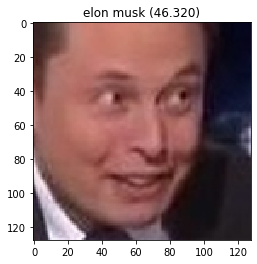

In [54]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4,5,6,7,8,9])
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
# print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
# print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()


# Predicting Single Image

1/1 [==============================] - 0s 187ms/step


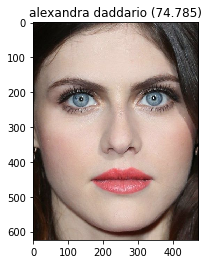

In [50]:
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.externals import joblib
import numpy as np


# SVM_MODEL LOAD FOR PREDICTION
model = joblib.load('models/128_svm_model.sav')
in_encoder = Normalizer()
out_encoder = LabelEncoder()

# Label Encoding
labels = np.load('data/label.npy',allow_pickle=True)
out_encoder.fit(labels)

# Read and process image for model
face_img = cv2.imread('daddario.jpg',1)
# face_img = face_img.astype('float32') / 255
rgb_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
img = cv2.resize(rgb_img, (128,128))


img = np.reshape(img, (1,img.shape[0], img.shape[1], img.shape[2]))
img_emd = np.asarray(get_embedding(img)) # converting embedded image to numpy array if needed


# Predicting Image
img_norm = in_encoder.transform(img_emd)
yhat_class = model.predict(img_norm)
yhat_prob = model.predict_proba(img_norm)

# Reverse Transform to Original label
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)

# Showing the prediction of given image 
plt.imshow(rgb_img)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()


In [2]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
le = LabelEncoder()
y = np.load('data/label.npy',allow_pickle=True)

le.fit(y)
# print(le.classes_)
y = le.inverse_transform([0,1,2,3,4,5,6,7,8,9])
print(y)

['Aaron Paul' 'Dwayne Johnson' 'Emma Stone' 'Rami Melek'
 'alexandra daddario' 'bill gates' 'drake' 'elon musk' 'mark zuckerberg'
 'shakira']


In [48]:
# from sklearn.externals import joblib

# filename = 'models/128_svm_model.sav'
# joblib.dump(model, filename)

['models/128_svm_model.sav']